In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
import pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                         summarize,
                         poly)
from ISLP import confusion_table
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from ISLP.models import sklearn_sm
from sklearn.model_selection import \
     (cross_validate,
      KFold,
      ShuffleSplit)
from sklearn.preprocessing import scale
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.preprocessing import StandardScaler

In [2]:
#Cleaning/Placing all Data together

In [3]:
df_health = pd.read_csv('https://raw.githubusercontent.com/b-pinter/COVID/main/data-QOKUW.csv')
df_income = pd.read_csv('https://raw.githubusercontent.com/b-pinter/COVID/main/average-income-by-state-2024.csv')
df_deaths = pd.read_csv('https://raw.githubusercontent.com/b-pinter/Spring-2024-Research/main/deaths_total.csv')
df_density = pd.read_csv('https://raw.githubusercontent.com/b-pinter/Spring-2024-Research/main/united-states-by-density-2024.csv')
df_total_population = pd.read_csv('https://raw.githubusercontent.com/b-pinter/Spring-2024-Research/main/State_Populations.csv')
df_poverty = pd.read_csv('https://raw.githubusercontent.com/b-pinter/Spring-2024-Research/main/Percentage-in-Poverty.csv')

In [4]:
test_1 = df_deaths.drop('Unnamed: 0',axis = 1)
test_2 = df_deaths.drop('Unnamed: 3', axis = 1)
df_deaths = test_2.drop('Unnamed: 4',axis = 1)

In [5]:
df_master = df_deaths.merge(df_health, on = 'State')
df_master = df_master.merge(df_income, on = 'State')
df_master = df_master.merge(df_density, on = 'State')
df_master = df_master.merge(df_total_population, on = 'State')
df_master = df_master.merge(df_poverty, on = 'State')

In [6]:
df_master.head()

,Unnamed: 0,State,Deaths,Rank,Disease Risk Factors & Prevalence Score¹,Substance Abuse Score²,Lifestyle Habits & Health Outlook Score³,Overall Score,AverageIncomePerCapita2022,AverageIncomePerCapita2021,densityMi,population,TotalArea,Pop. 2022,PercentInPoverty
0,NaN,California,101159,38,27.91,56.15,2.13,30.74,77339.0,76800.0,249.64706,38889770.0,163696.0,39029342,12.3
1,NaN,Texas,93390,24,54.10,0.00,51.02,45.76,61985.0,59802.0,118.57948,30976754.0,268596.0,30029572,14.2
2,NaN,Florida,86850,39,25.24,33.78,32.00,29.35,63597.0,62136.0,428.45559,22975931.0,65758.0,22244823,13.2
3,NaN,New York,77157,41,15.32,47.49,19.27,23.04,78089.0,76753.0,413.13143,19469232.0,54555.0,19677151,14.0
4,NaN,Pennsylvania,50398,26,33.76,53.82,49.02,42.97,65167.0,64042.0,289.45925,12951275.0,46054.0,12972008,12.0


In [7]:
df_master.drop(['Unnamed: 0','population','TotalArea','AverageIncomePerCapita2021','Rank'],axis=1,inplace=True)

In [8]:
df_master['Deaths Per Capita'] = df_master['Deaths']/df_master['Pop. 2022']
numerical_deaths = pd.to_numeric(df_master['Deaths'])
df_master['Deaths'] = numerical_deaths

In [9]:
df_master.head()

,State,Deaths,Disease Risk Factors & Prevalence Score¹,Substance Abuse Score²,Lifestyle Habits & Health Outlook Score³,Overall Score,AverageIncomePerCapita2022,densityMi,Pop. 2022,PercentInPoverty,Deaths Per Capita
0,California,101159,27.91,56.15,2.13,30.74,77339.0,249.64706,39029342,12.3,0.002592
1,Texas,93390,54.10,0.00,51.02,45.76,61985.0,118.57948,30029572,14.2,0.003110
2,Florida,86850,25.24,33.78,32.00,29.35,63597.0,428.45559,22244823,13.2,0.003904
3,New York,77157,15.32,47.49,19.27,23.04,78089.0,413.13143,19677151,14.0,0.003921
4,Pennsylvania,50398,33.76,53.82,49.02,42.97,65167.0,289.45925,12972008,12.0,0.003885


In [10]:
df_master.columns

Index(['State', 'Deaths', 'Disease Risk Factors & Prevalence Score¹',
       'Substance Abuse Score²', 'Lifestyle Habits & Health Outlook Score³',
       'Overall Score', 'AverageIncomePerCapita2022', 'densityMi', 'Pop. 2022',
       'PercentInPoverty', 'Deaths Per Capita'],
      dtype='object')

In [11]:
#Fig. 2
#Least Squares Model - US National
X, Y = df_master.drop(columns = ['Deaths Per Capita','State','Disease Risk Factors & Prevalence Score¹',
                                'Substance Abuse Score²','Lifestyle Habits & Health Outlook Score³','Deaths']), df_master['Deaths Per Capita']
(X_train,
 X_test,
 y_train,
 y_test) = train_test_split(X,
                            Y,
                            test_size=0.3)
#Fig. 3
model = sm.OLS(y_train, X_train)
results = model.fit()
summarize(results)

,coef,std err,t,P>|t|
Overall Score,1.695000e-05,7.570000e-06,2.239,0.033
AverageIncomePerCapita2022,7.886000e-09,7.340000e-09,1.074,0.292
densityMi,8.977000e-07,3.460000e-07,2.596,0.015
Pop. 2022,-1.892000e-12,1.270000e-11,-0.149,0.882
PercentInPoverty,1.000000e-04,6.230000e-05,2.360,0.025


In [12]:
#Fig. 4
results.rsquared

0.9743256590896086

In [13]:
#Creation of a Ridge Regression with prediction for Deaths Per Capita
scaler = StandardScaler(with_mean=True,
                        with_std=True,
                        copy=True)
scaler.fit(X)
X_scale = scaler.transform(X)

(X_train,
 X_test,
 y_train,
 y_test) = train_test_split(np.asarray(X_scale),
                            Y,
                            test_size=0.3)
alphas = 10**np.linspace(10,-2,100)*0.5

In [14]:
alphas

array([5.00000000e+09, 3.78231664e+09, 2.86118383e+09, 2.16438064e+09,
       1.63727458e+09, 1.23853818e+09, 9.36908711e+08, 7.08737081e+08,
       5.36133611e+08, 4.05565415e+08, 3.06795364e+08, 2.32079442e+08,
       1.75559587e+08, 1.32804389e+08, 1.00461650e+08, 7.59955541e+07,
       5.74878498e+07, 4.34874501e+07, 3.28966612e+07, 2.48851178e+07,
       1.88246790e+07, 1.42401793e+07, 1.07721735e+07, 8.14875417e+06,
       6.16423370e+06, 4.66301673e+06, 3.52740116e+06, 2.66834962e+06,
       2.01850863e+06, 1.52692775e+06, 1.15506485e+06, 8.73764200e+05,
       6.60970574e+05, 5.00000000e+05, 3.78231664e+05, 2.86118383e+05,
       2.16438064e+05, 1.63727458e+05, 1.23853818e+05, 9.36908711e+04,
       7.08737081e+04, 5.36133611e+04, 4.05565415e+04, 3.06795364e+04,
       2.32079442e+04, 1.75559587e+04, 1.32804389e+04, 1.00461650e+04,
       7.59955541e+03, 5.74878498e+03, 4.34874501e+03, 3.28966612e+03,
       2.48851178e+03, 1.88246790e+03, 1.42401793e+03, 1.07721735e+03,
      

In [15]:
#US National Ridge Regression
ridge = Ridge()
coefs = []
MSEs = []

for a in alphas:
    ridge.set_params(alpha = a)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)
    pred = ridge.predict(X_test)
    MSEs.append(mean_squared_error(y_test, pred))

Text(0, 0.5, 'MSE')

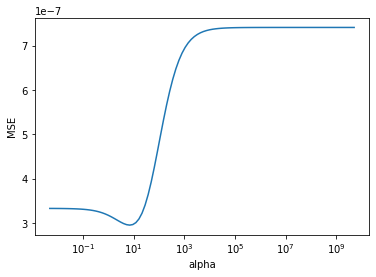

In [16]:
plt.plot(alphas, MSEs)
plt.xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('MSE')

In [17]:
ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error')
ridgecv.fit(X_scale, Y)
print(ridgecv.alpha_)

7.087370814634009


In [18]:
best_score = ridgecv.best_score_
best_score

-3.4112482247144366e-07

In [19]:
#R-Squared Score for National Model
print(ridgecv.score(X_scale,Y))

0.6208476863994257


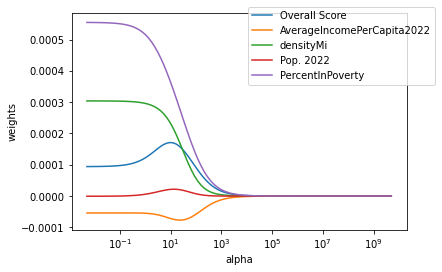

In [20]:
plt.plot(alphas, coefs, label = X.columns)
plt.xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.legend(bbox_to_anchor=(1.1, 1.05))

In [21]:
Northeast = ["Connecticut", "Maine", "Massachusetts", "New Hampshire", "Rhode Island", "Vermont", "New Jersey", "New York", "Pennsylvania","Delaware","Maryland"]
Midwest = ["Illinois", "Indiana", "Iowa", "Michigan", "Minnesota", "Missouri", "Nebraska", "North Dakota", "Ohio", "South Dakota", "Wisconsin"]
South =  ["Alabama", "Arkansas",  "Florida", "Georgia", "Kentucky", "Louisiana", "Mississippi", "North Carolina", "Oklahoma", "South Carolina", "Tennessee", "Texas", "Virginia", "West Virginia"]
West = ["Alaska", "Arizona", "California", "Colorado", "Hawaii", "Idaho", "Montana", "Nevada", "New Mexico", "Oregon", "Utah", "Washington", "Wyoming"]

In [22]:
#Fig. 1
df_northeast = df_master[df_master['State'].isin(Northeast)]
df_midwest = df_master[df_master['State'].isin(Midwest)]
df_south = df_master[df_master['State'].isin(South)]
df_west = df_master[df_master['State'].isin(West)]

In [23]:
#Bootstraping
df_northeast = df_master.sample(n = 50, replace = True)
df_midwest = df_master.sample(n = 50, replace = True)
df_south = df_master.sample(n = 50, replace = True)
df_west = df_master.sample(n = 50, replace = True)

In [24]:
#Northeast Least Squares Model and Ridge Regression
X1, Y1 = df_northeast.drop(columns = ['Deaths Per Capita','State','Disease Risk Factors & Prevalence Score¹',
                                'Substance Abuse Score²','Lifestyle Habits & Health Outlook Score³','Deaths']), df_northeast['Deaths Per Capita']
(X_train1,
 X_test1,
 y_train1,
 y_test1) = train_test_split(X1,
                            Y1,
                            test_size=0.3)
model = sm.OLS(y_train1, X_train1)
results2 = model.fit()
summarize(results2)
#Northeast Least Squares

,coef,std err,t,P>|t|
Overall Score,7.230000e-06,6.430000e-06,1.124,0.270
AverageIncomePerCapita2022,5.774000e-09,5.990000e-09,0.964,0.343
densityMi,5.901000e-07,5.230000e-07,1.128,0.268
Pop. 2022,-1.249000e-11,1.960000e-11,-0.636,0.529
PercentInPoverty,2.000000e-04,5.160000e-05,3.898,0.001


In [25]:
#Northeast R-Squared
results2.rsquared

0.9877117164146335

In [26]:
scaler = StandardScaler(with_mean=True,
                        with_std=True,
                        copy=True)
scaler.fit(X1)
X_scale1 = scaler.transform(X1)

(X_train1,
 X_test1,
 y_train1,
 y_test1) = train_test_split(np.asarray(X_scale1),
                            Y1,
                            test_size=0.3)

In [27]:
ridge = Ridge()
coefs = []
MSEs = []

for a in alphas:
    ridge.set_params(alpha = a)
    ridge.fit(X_train1, y_train1)
    coefs.append(ridge.coef_)
    pred1 = ridge.predict(X_test1)
    MSEs.append(mean_squared_error(y_test1, pred1))

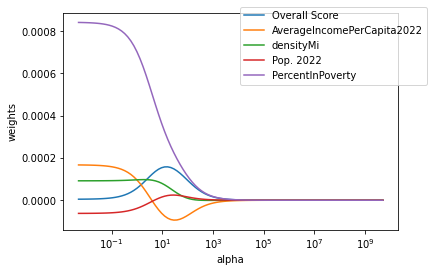

In [28]:
plt.plot(alphas, coefs, label = X1.columns)
plt.xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.legend(bbox_to_anchor=(1.1, 1.05))

In [29]:
ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error')
ridgecv.fit(X_scale1, Y1)
print(ridgecv.alpha_)

2.320794416806386


In [30]:
print(ridgecv.score(X_scale1,Y1))

0.7426688107879996


In [31]:
#Midwest Lease Squares Regression and Ridge Regression
X2, Y2 = df_midwest.drop(columns = ['Deaths Per Capita','State','Disease Risk Factors & Prevalence Score¹',
                                'Substance Abuse Score²','Lifestyle Habits & Health Outlook Score³','Deaths']), df_midwest['Deaths Per Capita']
(X_train2,
 X_test2,
 y_train2,
 y_test2) = train_test_split(X2,
                            Y2,
                            test_size=0.3)
model = sm.OLS(y_train2, X_train2)
results3 = model.fit()
summarize(results3)
#Midwest Least Squares

,coef,std err,t,P>|t|
Overall Score,1.047000e-05,5.200000e-06,2.013,0.053
AverageIncomePerCapita2022,4.739000e-09,4.390000e-09,1.079,0.289
densityMi,4.835000e-07,3.840000e-07,1.260,0.217
Pop. 2022,-1.767000e-11,1.350000e-11,-1.305,0.202
PercentInPoverty,2.000000e-04,3.320000e-05,5.626,0.000


In [32]:
#Midwest R-Squared
results3.rsquared

0.9869796609267927

In [33]:
scaler = StandardScaler(with_mean=True,
                        with_std=True,
                        copy=True)
scaler.fit(X2)
X_scale2 = scaler.transform(X2)

(X_train2,
 X_test2,
 y_train2,
 y_test2) = train_test_split(np.asarray(X_scale2),
                            Y2,
                            test_size=0.3)

In [34]:
ridge = Ridge()
coefs = []
MSEs = []

for a in alphas:
    ridge.set_params(alpha = a)
    ridge.fit(X_train2, y_train2)
    coefs.append(ridge.coef_)
    pred2 = ridge.predict(X_test2)
    MSEs.append(mean_squared_error(y_test2, pred2))

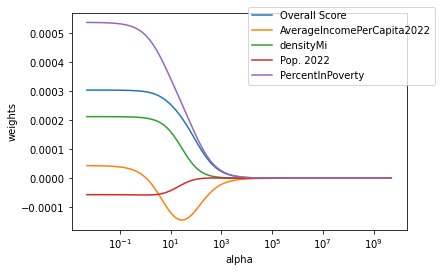

In [35]:
plt.plot(alphas, coefs, label = X2.columns)
plt.xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.legend(bbox_to_anchor=(1.1, 1.05))

In [36]:
ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error')
ridgecv.fit(X_scale2, Y2)
print(ridgecv.alpha_)

2.320794416806386


In [37]:
print(ridgecv.score(X_scale2,Y2))

0.7912364826268725


In [38]:
#South Lease Squares Regression and Ridge Regression
X3, Y3 = df_south.drop(columns = ['Deaths Per Capita','State','Disease Risk Factors & Prevalence Score¹',
                                'Substance Abuse Score²','Lifestyle Habits & Health Outlook Score³','Deaths']), df_south['Deaths Per Capita']
(X_train3,
 X_test3,
 y_train3,
 y_test3) = train_test_split(X3,
                            Y3,
                            test_size=0.3)
model = sm.OLS(y_train3, X_train3)
results4 = model.fit()
summarize(results4)
#Southern US Least Squares

,coef,std err,t,P>|t|
Overall Score,1.666000e-05,5.190000e-06,3.208,0.003
AverageIncomePerCapita2022,7.634000e-09,7.560000e-09,1.009,0.321
densityMi,8.521000e-07,5.230000e-07,1.630,0.114
Pop. 2022,-7.604000e-12,1.700000e-11,-0.447,0.658
PercentInPoverty,1.000000e-04,4.300000e-05,3.346,0.002


In [39]:
#Southern US R-Squared
results4.rsquared

0.9843772153742959

In [40]:
scaler = StandardScaler(with_mean=True,
                        with_std=True,
                        copy=True)
scaler.fit(X3)
X_scale3 = scaler.transform(X3)

(X_train3,
 X_test3,
 y_train3,
 y_test3) = train_test_split(np.asarray(X_scale3),
                            Y3,
                            test_size=0.3)

In [41]:
ridge = Ridge()
coefs = []
MSEs = []

for a in alphas:
    ridge.set_params(alpha = a)
    ridge.fit(X_train3, y_train3)
    coefs.append(ridge.coef_)
    pred3 = ridge.predict(X_test3)
    MSEs.append(mean_squared_error(y_test3, pred3))

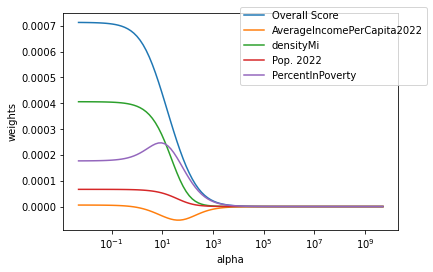

In [42]:
plt.plot(alphas, coefs, label = X3.columns)
plt.xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.legend(bbox_to_anchor=(1.1, 1.05))

In [43]:
ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error')
ridgecv.fit(X_scale3, Y3)
print(ridgecv.alpha_)

2.320794416806386


In [44]:
print(ridgecv.score(X_scale3,Y3))

0.7231170870512851


In [45]:
#West Lease Squares Regression and Ridge Regression
X4, Y4 = df_west.drop(columns = ['Deaths Per Capita','State','Disease Risk Factors & Prevalence Score¹',
                                'Substance Abuse Score²','Lifestyle Habits & Health Outlook Score³','Deaths']), df_west['Deaths Per Capita']
(X_train4,
 X_test4,
 y_train4,
 y_test4) = train_test_split(X4,
                            Y4,
                            test_size=0.3)
model = sm.OLS(y_train4, X_train4)
results5 = model.fit()
summarize(results5)
#Western US Least Squares

,coef,std err,t,P>|t|
Overall Score,1.598000e-05,7.410000e-06,2.157,0.039
AverageIncomePerCapita2022,9.260000e-09,8.390000e-09,1.104,0.278
densityMi,8.966000e-07,4.060000e-07,2.210,0.035
Pop. 2022,-7.384000e-13,1.260000e-11,-0.059,0.953
PercentInPoverty,1.000000e-04,6.290000e-05,2.331,0.027


In [46]:
#Western US R-Squared
results5.rsquared

0.9770855709513968

In [47]:
scaler = StandardScaler(with_mean=True,
                        with_std=True,
                        copy=True)
scaler.fit(X4)
X_scale4 = scaler.transform(X4)

(X_train4,
 X_test4,
 y_train4,
 y_test4) = train_test_split(np.asarray(X_scale4),
                            Y4,
                            test_size=0.3)

In [48]:
ridge = Ridge()
coefs = []
MSEs = []

for a in alphas:
    ridge.set_params(alpha = a)
    ridge.fit(X_train4, y_train4)
    coefs.append(ridge.coef_)
    pred4 = ridge.predict(X_test4)
    MSEs.append(mean_squared_error(y_test4, pred4))

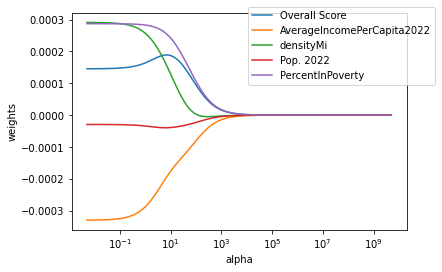

In [49]:
plt.plot(alphas, coefs, label = X4.columns)
plt.xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.legend(bbox_to_anchor=(1.1, 1.05))

In [50]:
ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error')
ridgecv.fit(X_scale4, Y4)
print(ridgecv.alpha_)

7.087370814634009


In [51]:
print(ridgecv.score(X_scale4,Y4))

0.6595459868761686
